In [17]:
import sys
sys.path.append("../src")

In [18]:
import os
import warnings

import h5py
import numpy as np

from population_analysis.consts import TOTAL_TRIAL_MS, PRE_TRIAL_MS, POST_TRIAL_MS
from population_analysis.population.units import UnitPopulation
from population_analysis.processors import RawSessionProcessor

SESSION_DATA_PATH = "E:\\PopulationAnalysis"


def dictify_hd5(data):
    import h5py
    if isinstance(data, h5py.Dataset):
        try:
            return list(data[:])
        except Exception as e:
            print(f"Errorrrrrr {str(e)}")
            return "BROKEN!!!!!!!!!!!!!!!!!!!!!!"
    else:
        dd = dict(data)
        d = {}
        for k, v in dd.items():
            d[k] = dictify_hd5(v)
        return d


def check_for_data(folder_path, data_files):
    folders = os.listdir(folder_path)
    for mouse_folder in folders:
        if mouse_folder.startswith("mlati"):
            # TODO? Only use mlati mice
            files = os.listdir(os.path.join(folder_path, mouse_folder))
            for file in files:
                if file.endswith(".hdf"):
                    data_files[f"{os.path.basename(folder_path)}-{mouse_folder}"] = os.path.join(folder_path, mouse_folder, file)
    tw = 2

In [3]:
data_files = {}
for folder in os.listdir(SESSION_DATA_PATH):
    check_for_data(os.path.join(SESSION_DATA_PATH, folder), data_files)

filename = list(data_files.items())[0][1]

try:
    sess = RawSessionProcessor(filename)
    sess.save_to_nwb("mlati9", "session0")  # TODO change me
except Exception as e:
    warnings.warn(f"Exception processing file '{filename}' skipping. Error: '{str(e)}'")


Extracting saccade spike timestamps..
 0.0% 9.96% 19.92% 29.89% 39.85% 49.81% 59.77% 69.73% 79.7% 89.66% 99.62%
Extracting probe spike timestamps..
 0.0% 10.0% 19.99% 29.99% 39.98% 49.98% 59.97% 69.97% 79.96% 89.96% 99.95%
Demixing saccades within 500ms from a probe
Demixing probes within 500ms of a saccade
Calculating firing rates for all trials and units 0.0 % 0.1 % 0.2 % 0.3 % 0.4 % 0.5 % 0.6 % 0.7 % 0.8 % 0.9 % 1.0 %


In [19]:
import h5py
import numpy as np
import pendulum
from pynwb.file import Subject
from simply_nwb import SimpleNWB

from population_analysis.consts import PRE_TRIAL_MS, POST_TRIAL_MS, SESSION_DESCRIPTION, EXPERIMENTERS, \
    EXPERIMENT_DESCRIPTION, MOUSE_DETAILS, EXPERIMENT_KEYWORDS, DEVICE_NAME, DEVICE_DESCRIPTION, DEVICE_MANUFACTURER
from population_analysis.population.units import UnitPopulation


ImportError: cannot import name 'DEVICE_NAME' from 'population_analysis.consts' (C:\Users\spenc\Documents\GitHub\SaccadePopulationAnalysis\notebooks\../src\population_analysis\consts.py)

In [45]:
from pynwb import TimeSeries

SESSION_DESCRIPTION = "sess desc"  # TODO change me
EXPERIMENT_DESCRIPTION = "TODO"  # TODO Change me
EXPERIMENT_KEYWORDS = ["mouse", "neuropixels"]
EXPERIMENTERS = [
    "Hunt, Josh"
]

DEVICE_NAME = "neuropixels-probe"
DEVICE_DESCRIPTION = "neuropixels probe"
DEVICE_MANUFACTURER = "neuropixels"
self = sess
mouse_name = "mlati9"
session_id = "session0"
if self._unit_pop is None:
    self.calc_unit_population_stats()

In [78]:
if self._unit_pop is None:
    self.calc_unit_population_stats()

birthday_diff = pendulum.now().diff(MOUSE_DETAILS[mouse_name]["birthday"])

nwb = SimpleNWB.create_nwb(
    # Required
    session_description=SESSION_DESCRIPTION,
    # Subtract 1 year so we don't run into the 'NWB start time is at a greater date than current' issue
    session_start_time=pendulum.now().subtract(years=1),
    experimenter=EXPERIMENTERS,
    lab="Felsen Lab",
    experiment_description=EXPERIMENT_DESCRIPTION,
    # Optional
    identifier=mouse_name,
    subject=Subject(**{
        "subject_id": mouse_name,
        "age": f"P{birthday_diff.days}D",  # ISO-8601 for days duration
        "strain": MOUSE_DETAILS[mouse_name]["strain"],
        "description": f"Mouse id '{mouse_name}'",
        "sex": MOUSE_DETAILS[mouse_name]["sex"]
    }),
    session_id=session_id,
    institution="CU Anschutz",
    keywords=EXPERIMENT_KEYWORDS,
    # related_publications="DOI::LINK GOES HERE FOR RELATED PUBLICATIONS"
)

# Add device
nwb.create_device(
    name=DEVICE_NAME, description=DEVICE_DESCRIPTION, manufacturer=DEVICE_MANUFACTURER
)

# Add units
nwb.add_unit_column(name="trial_firing_rates",
                    description="trials x waveform length array for each unit's presence in a trial")
for unit_num in range(self.unit_pop.num_units):
    unit_spike_idxs = np.where(self.unit_pop.spike_clusters == unit_num)
    spike_times = self.unit_pop.spike_timestamps[unit_spike_idxs]
    nwb.add_unit(
        spike_times=spike_times,
        trial_firing_rates=self.unit_pop.unit_firingrates[unit_num]
    )

# Add probe and saccade event timings, trial types
behavior_events = nwb.create_processing_module(name="behavior",
                                               description="Contains saccade and probe event timings")

probe_ts = TimeSeries(name="probes", data=self.probe_timestamps, unit="s", rate=0.001)
saccade_ts = TimeSeries(name="saccades", data=self.saccade_timestamps, unit="s", rate=0.001)

# trial_types = self.unit_pop.get_trial_labels()
trial_types = np.array([tr.trial_label for tr in self.unit_pop._trials])
unique_trial_types = np.unique(trial_types)
for trial_type in unique_trial_types:
    behavior_events.add(TimeSeries(name=f"trial-{trial_type}",
                                   data=np.where(trial_types == trial_type)[0], rate=1.0, unit="idx"))
behavior_events.add(probe_ts)
behavior_events.add(saccade_ts)

saccades pynwb.base.TimeSeries at 0x2889350178224
Fields:
  comments: no comments
  conversion: 1.0
  data: [  58.314   93.928  113.59  ... 7428.69  7441.463 7442.148]
  description: no description
  offset: 0.0
  rate: 0.001
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: s

In [82]:
# nwb.processing["behavior"]["trial-mixed"].data
#from simply_nwb import SimpleNWB
SimpleNWB.write(nwb, "2023-05-16_mlati7_output.nwb")

root pynwb.file.NWBFile at 0x2889350177744
Fields:
  devices: {
    neuropixels-probe <class 'pynwb.device.Device'>
  }
  experiment_description: TODO
  experimenter: ['Hunt, Josh']
  file_create_date: [datetime.datetime(2024, 3, 11, 19, 36, 59, 910833, tzinfo=tzlocal())]
  identifier: mlati9
  institution: CU Anschutz
  keywords: ['mouse' 'neuropixels']
  lab: Felsen Lab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_description: sess desc
  session_id: session0
  session_start_time: 2023-03-11 19:36:59.910833-07:00
  subject: subject pynwb.file.Subject at 0x2889350177888
Fields:
  age: P6958D
  age__reference: birth
  description: Mouse id 'mlati9'
  sex: M
  strain: mouse
  subject_id: mlati9

  timestamps_reference_time: 2023-03-11 19:36:59.910833-07:00
  units: units <class 'pynwb.misc.Units'>

In [84]:
from pynwb import NWBHDF5IO as io
f = io("2023-05-16_mlati7_output.nwb")

In [85]:
new_nwb = f.read()

In [86]:
new_nwb

root pynwb.file.NWBFile at 0x2889507565472
Fields:
  devices: {
    neuropixels-probe <class 'pynwb.device.Device'>
  }
  experiment_description: TODO
  experimenter: ['Hunt, Josh']
  file_create_date: [datetime.datetime(2024, 3, 11, 19, 36, 59, 910833, tzinfo=tzoffset(None, -21600))]
  identifier: mlati9
  institution: CU Anschutz
  keywords: <StrDataset for HDF5 dataset "keywords": shape (2,), type "|O">
  lab: Felsen Lab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>
  }
  session_description: sess desc
  session_id: session0
  session_start_time: 2023-03-11 19:36:59.910833-07:00
  subject: subject pynwb.file.Subject at 0x2889506585424
Fields:
  age: P6958D
  age__reference: birth
  description: Mouse id 'mlati9'
  sex: M
  strain: mouse
  subject_id: mlati9

  timestamps_reference_time: 2023-03-11 19:36:59.910833-07:00
  units: units <class 'pynwb.misc.Units'>

In [87]:
times = new_nwb.units["trial_firing_rates"][1][9]

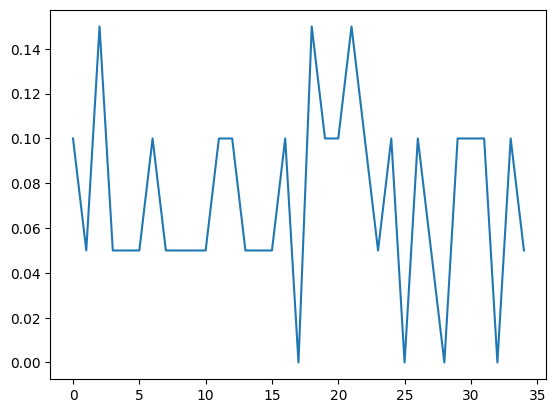

In [88]:
import matplotlib.pyplot as plt
plt.plot(times)